# CNN - How Many Fingers? Using PyTorch

This notebook contains all the steps that were taken to train, validate, and analyze a convolutional neural network to predict how many figers are been held up with the edges of a hand against a plain background.

An application within this replository uses the CNN and openCV to the make the predictions real-time. It also offers capabilities to collect data for training. The dataset was collected using this application by holding up 0 to 5 fingers in the region of interest and storing the images. The original dataset from the tensorflow baseline was used, for which `each label contains about 1500 images plus an additional 600 images for validation.`

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from pytorch_model_summary import summary
import time
import os
import copy

# plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Dataset

The first step is to load the data that was collected in the app.
Use torchvision's dataset `ImageFolder` to load the data and do any augmentations ('transfomations'). 
Augmenting the training data with shifts, rotations, zooms, and mirroring will prevent biased to any right or less hand and improve training for diffent hand movements.

Use torch.utils.data `DataLoader` to prepare the data for training, as this will shuffle the data, divide it into batches, and set the number of cores to use.

-------------------- Data augmentations --------------------
- rescale/resize                => transforms.Resize(300)
- normalize                     => transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225]) OR transforms.Normalize(mean=[0.5], std=[0.225])

                                =>ToTensor automatically convert all images between 0 - 1
- rotations(10 degrees)         => transforms.RandomRotation(10)
- shifts(x_position, y_postion) => transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1))
- zoom(0.2)                     => transforms.RandomAffine(degrees=0, scale=(.8, 1))
- mirroring                     => RandomHorizontalFlip()

In [2]:
DATA_PATH = './images/'
BATCH_SIZE = 128
NUM_WORKERS = 4

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(300),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1)),
        transforms.RandomAffine(degrees=0, scale=(.8, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ]),
    'val': transforms.Compose([
        transforms.Resize(300),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [3]:
print("Classes: ", class_names)
print("Number of train samples: ", len(image_datasets['train']))
print("Number of test/validation samples: ", len(image_datasets['val']))
print("# of training batches (steps per epoch): ", len(dataloaders['train']))
print("# of validation batches (validation steps): ", len(dataloaders['val']))

Classes:  ['FIVE', 'FOUR', 'NONE', 'ONE', 'THREE', 'TWO']
Number of train samples:  9081
Number of test/validation samples:  3632
# of training batches (steps per epoch):  71
# of validation batches (validation steps):  29


There should be an equal examples for each label to prevent any bias in the model

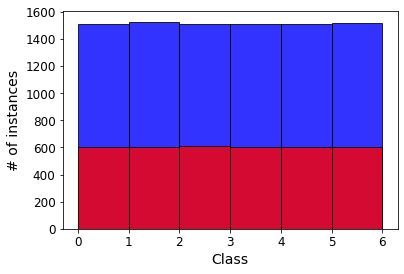

In [4]:
h1,_,_ = plt.hist(np.array(image_datasets['train'].targets), bins=range(0,7), alpha=0.8, color='blue', edgecolor='black')
h2,_,_ = plt.hist(np.array(image_datasets['val'].targets),  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class');

torch.Size([1, 300, 300])


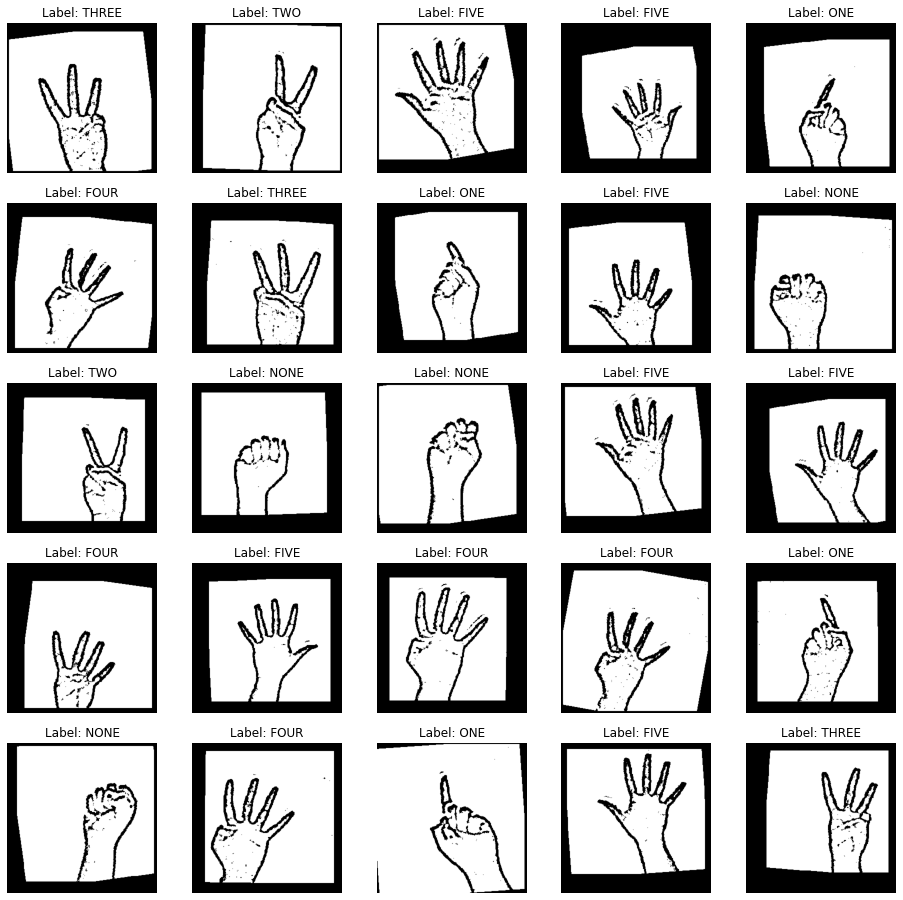

In [5]:
for batch_idx, (data, target) in enumerate(dataloaders['train']): 
    print(data[0].shape) # [Color, Height, Width]

    plt.figure(figsize=(16, 16))
    for i in range(25):
        img = data[i].permute(1, 2, 0) # rotates and transposes image tensor from [C, H, W] to get [H, W, C]
        label = target[i].item()
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title("Label: {}".format(class_names[label]))
        plt.imshow(img, cmap='gray')
    if batch_idx == 0: break # only see images from the first batch

Check to ensure that the data is labeled correctly

In [6]:
# double check things aren't mixed up
image_datasets['train'].class_to_idx == image_datasets['val'].class_to_idx

True

## Convolutional Neural Net

The data appears approapiate enough, hence a CNN model needs to be define to training and use in the app. The model defined below seems to perform well enough for this purpose, though it can be still be optimized.

- kernel_size =>  a 2-tuple specifying the width and height of the 2D convolution window. (A single value represents the same value for width and heigth)

***For nn.Linear you would have to provide the number if in_features first, which can be calculated using your layers and input shape or just by printing out the shape of the activation in your forward method.



In [2]:
# model with input_shape = (300, 300, 1)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input_channels = 1, output channels = 6, kernel_size=(3,3)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2) # same as pool_size=(2,2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.pool4 = nn.MaxPool2d(2)

        self.hidden= nn.Linear(128*16*16, 512) # The linear layer should therefore take 128*16*16=32768 input features
        self.drop = nn.Dropout(0.3) # 30% probability of an element to be zeroed
        self.out = nn.Linear(512, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # -> [batch_size, 32, 298, 298] => The 32 is given by the number of kernels your conv layer is using.
                                                                    # Since you are not using any padding and leave the stride and dilation as 1,
                                                                    # a kernel size of 3 will crop 1 pixel in each spatial dimension.
                                                                    # Therefore you’ll end up with 32 activation maps of spatial size 298x298.
        # print(x.shape)
        x = self.pool1(x) # -> [batch_size, 32, 149, 149] => The max pooling layer will halve the spatial size
        # print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim=1)
        #x = torch.flatten(x, start_dim=1) # flattens a contiguous range of dims in a tensor
        #x = x.view(x.size(0), -1) # also flattens -> [batch_size, 128*16*16=32768]
        x = F.relu(self.hidden(x)) # -> [batch_size, 512]
        x = self.drop(x) # -> [batch_size, 512]
        x = self.out(x)
        x = F.softmax(x, dim=1) # -> [batch_size, 6]
        return x


In [19]:
""" **********------ FOR TESTING ------**********"""
# batch_size, C, H, W = 1, 1, 300, 300
# x = torch.randn(batch_size, C, H, W)
# output = model(x)

' **********------ FOR TESTING ------**********'

In [8]:
model = CNN()
print(summary(model, torch.zeros((1, 1, 300, 300)), show_input=False, show_hierarchical=True))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 32, 298, 298]             320             320
       MaxPool2d-2     [1, 32, 149, 149]               0               0
          Conv2d-3     [1, 64, 147, 147]          18,496          18,496
       MaxPool2d-4       [1, 64, 73, 73]               0               0
          Conv2d-5      [1, 128, 71, 71]          73,856          73,856
       MaxPool2d-6      [1, 128, 35, 35]               0               0
          Conv2d-7      [1, 128, 33, 33]         147,584         147,584
       MaxPool2d-8      [1, 128, 16, 16]               0               0
          Linear-9              [1, 512]      16,777,728      16,777,728
        Dropout-10              [1, 512]               0               0
         Linear-11                [1, 6]           3,078           3,078
Total params: 17,021,062
Trainable params: 17,021,

Construct a loss function, an optimizer, and a learning rate scheduler

In [9]:
criterion = nn.CrossEntropyLoss() # loss

optimizer = optim.Adadelta(model.parameters(), lr=1.0) # optimizer
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1) # learning rate scheduler

## Training

- Training will save the best model.

- We will not define a separate testing and validation set since the model can be further tested in real time within the app. 

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden): Linear(in_features=32768, out_features=512, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=512, out_features=6, bias=True)
)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    training_start_time = time.time()
 
    loss_history = dict()
    train_loss_history = []    
    val_loss_history = []
    
    acc_history = dict()
    train_acc_history = []    
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        epoch_start_time = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('>>> {:5} -- Loss: {:.4f} | Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

        epoch_time_elapsed = time.time() - epoch_start_time
        print('-' * 40, '{:.0f}m {:.0f}s'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))

    total_time_elapsed = time.time() - training_start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    loss_history['train'] = train_loss_history
    loss_history['val'] = val_loss_history
    
    acc_history['train'] = train_acc_history
    acc_history['val'] = val_acc_history
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history

In [12]:
# Test #14 (repeated)
NUM_EPOCHS = 40
PATH = './model_test14-2.pth'
best_model, acc_history, loss_history = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=NUM_EPOCHS)
torch.save(best_model.state_dict(), PATH)

Epoch 1/40
>>> train -- Loss: 1.7582 | Acc: 0.2462
>>> val   -- Loss: 1.6004 | Acc: 0.4496
---------------------------------------- 0m 25s
Epoch 2/40
>>> train -- Loss: 1.5841 | Acc: 0.4471
>>> val   -- Loss: 1.3639 | Acc: 0.6735
---------------------------------------- 0m 25s
Epoch 3/40
>>> train -- Loss: 1.3924 | Acc: 0.6504
>>> val   -- Loss: 1.2209 | Acc: 0.8224
---------------------------------------- 0m 25s
Epoch 4/40
>>> train -- Loss: 1.2777 | Acc: 0.7639
>>> val   -- Loss: 1.1558 | Acc: 0.8893
---------------------------------------- 0m 25s
Epoch 5/40
>>> train -- Loss: 1.2157 | Acc: 0.8269
>>> val   -- Loss: 1.1423 | Acc: 0.9012
---------------------------------------- 0m 25s
Epoch 6/40
>>> train -- Loss: 1.1788 | Acc: 0.8631
>>> val   -- Loss: 1.1507 | Acc: 0.8918
---------------------------------------- 0m 25s
Epoch 7/40
>>> train -- Loss: 1.1628 | Acc: 0.8797
>>> val   -- Loss: 1.1118 | Acc: 0.9306
---------------------------------------- 0m 25s
Epoch 8/40
>>> train -- Los

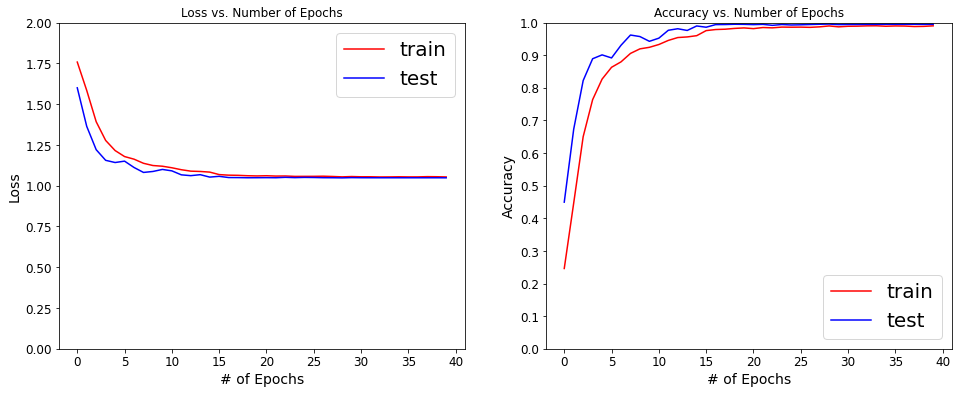

In [13]:
train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

train_loss_hist = [h for h in loss_history['train']]
val_loss_hist = [h for h in loss_history['val']]
train_acc_hist = [h.cpu().numpy() for h in acc_history['train']]
val_acc_hist = [h.cpu().numpy() for h in acc_history['val']]

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("Loss vs. Number of Epochs")
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.plot(range(NUM_EPOCHS), train_loss_hist,'r-', label="train")
plt.plot(range(NUM_EPOCHS), val_loss_hist,'b-', label="test")
plt.ylim((0,2))
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5.0))
plt.legend(prop={'size': 20}, loc='upper right')
plt.subplot(1,2,2)
plt.title("Accuracy vs. Number of Epochs")
plt.xlabel("# of Epochs")
plt.ylabel("Accuracy")
plt.plot(range(NUM_EPOCHS), train_acc_hist,'r-', label="train")
plt.plot(range(NUM_EPOCHS), val_acc_hist,'b-', label="test")
plt.ylim((0,1.))
plt.xticks(np.arange(0, NUM_EPOCHS+1, 5.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(prop={'size': 20}, loc='lower right')
plt.show()

It is not surprising that the validation set is performing better than the training as random augmentations were applied to the training set and the dropout being applied in the network. Even so, it appears that the model achieves an overall nearly-perfect accuracy > 99% .

However there seems to be an issue with loss as it is converging near 1. This might not be a critical issue if model accurancy and performance is acceptable for purposes of this project. Future further investigation might could necessary.

Nonetheless, this model is able to hence surpass human performance when the human has a critical brain injury or is severely intoxicated.

## Performance and Error Analysis

The model is performing very well to the point that there are not many observations of model failing to help understand it better.
Still, to understand the model in more depth, we can use the testing dataset with some applied augmentations.

`Since we are not defining a separate validation and testing set, for organization purposes we will rename the images valiation folder to 'test' before moving foward.`

In [3]:
criterion = nn.CrossEntropyLoss() # only need the loss function to evaluate model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# PATH = './models/model_test15.pth'
PATH = 'model_test15.pth'
model = CNN()
if device == torch.device('cpu'): # load on CPU
    model.load_state_dict(torch.load(PATH, map_location=device)) # must deserialize the saved state_dict before passing
else: # load on GPU
    model.load_state_dict(torch.load(PATH))
    model.to(device)
model.eval() # set dropout and batch normalization layers to evaluation mode

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden): Linear(in_features=32768, out_features=512, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=512, out_features=6, bias=True)
)

In [4]:
DATA_PATH = './images/'
BATCH_SIZE = 128
NUM_WORKERS = 4
# augmentations adds variations to testing test to better analyze performance 
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(300),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1 ,0.1)),
        transforms.RandomAffine(degrees=0, scale=(.8, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
               for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes
print("There are {} testing images beloging to {} classes.".format(len(image_datasets['test']), len(class_names)))

There are 3632 testing images beloging to 6 classes.


In [5]:
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
incorrect_examples, incorrect_preds, incorrect_target = [], [], []
all_test_preds, all_test_targets = [], []
# all_test_preds, all_test_targets = torch.tensor([]), torch.tensor([])

for batch_idx, (data, target) in enumerate(dataloaders['test']): # total of 29 validation batches / 'validation steps'
    data, target = data.to(device), target.to(device) # move tensors to GPU or CPU 
    output = model(data) # forward pass
    loss = criterion(output, target) # batch loss
    test_loss += loss.item() * data.size(0) # test loss update
    _, preds = torch.max(output, 1) # convert output probabilities to predicted class    
    correct_tensor = preds.eq(target.data.view_as(preds)) # compare predictions to true label
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    # test_examples = torch.cat((test_preds, preds), dim=0) 
    #all_test_preds = torch.cat((all_test_preds, output.data.cpu()), dim=0) #to use later -> all_test_preds.argmax(dim=1)
    
    # calculate test accuracy for each object class
    for i in range(len(target.data)): # number of examples per batch; all have 128, except last one has 48
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        # calculate confusion matrix
        all_test_preds.append(preds[i].item())
        all_test_targets.append(target[i].item())
        
        # incorrect predictions
        if preds.data[i] != target.data[i]:
            temp = data[i].permute(1, 2, 0) # converts image tensor from [C, H, W] to get [H, W, C]
            incorrect_examples.append(temp.cpu().numpy())
            incorrect_preds.append(preds[i].item())
            incorrect_target.append(target[i].item())
            
print("Number of images in each class:", class_total)

# # average test loss
# test_loss = test_loss/len(dataloaders['test'].dataset)
# print(f'Test Loss: {round(test_loss, 6)}')

# test accuracy
for i in range(len(class_names)):
    if class_total[i] > 0:
        print(f'Test Accuracy of {class_names[i]}: {round(100*class_correct[i]/class_total[i], 2)}%')
    else:
        print(f'Test Accuracy of {class_names[i]}s: N/A (no training examples)')

overall_acc = round(100. * np.sum(class_correct) / np.sum(class_total), 2)
bad_predictions = int(np.sum(class_total) - np.sum(class_correct))

print(f'Full Test Accuracy: {overall_acc}% ----- {np.sum(class_correct)} out of {np.sum(class_total)}')

Number of images in each class: [606.0, 604.0, 607.0, 605.0, 605.0, 605.0]
Test Accuracy of FIVE: 98.68%
Test Accuracy of FOUR: 96.36%
Test Accuracy of NONE: 99.84%
Test Accuracy of ONE: 99.83%
Test Accuracy of THREE: 99.5%
Test Accuracy of TWO: 98.51%
Full Test Accuracy: 98.79% ----- 3588.0 out of 3632.0


In [6]:
print("There are a {} examples of bad predictions".format(bad_predictions))
print(len(incorrect_examples))

There are a 44 examples of bad predictions
44


The accuracy appears (<1 to 2%) lower than validated during training which is likely due to the augmentations that were added to the testing set.

Let's also look at some of the images that were predicted incorrectly by the model.

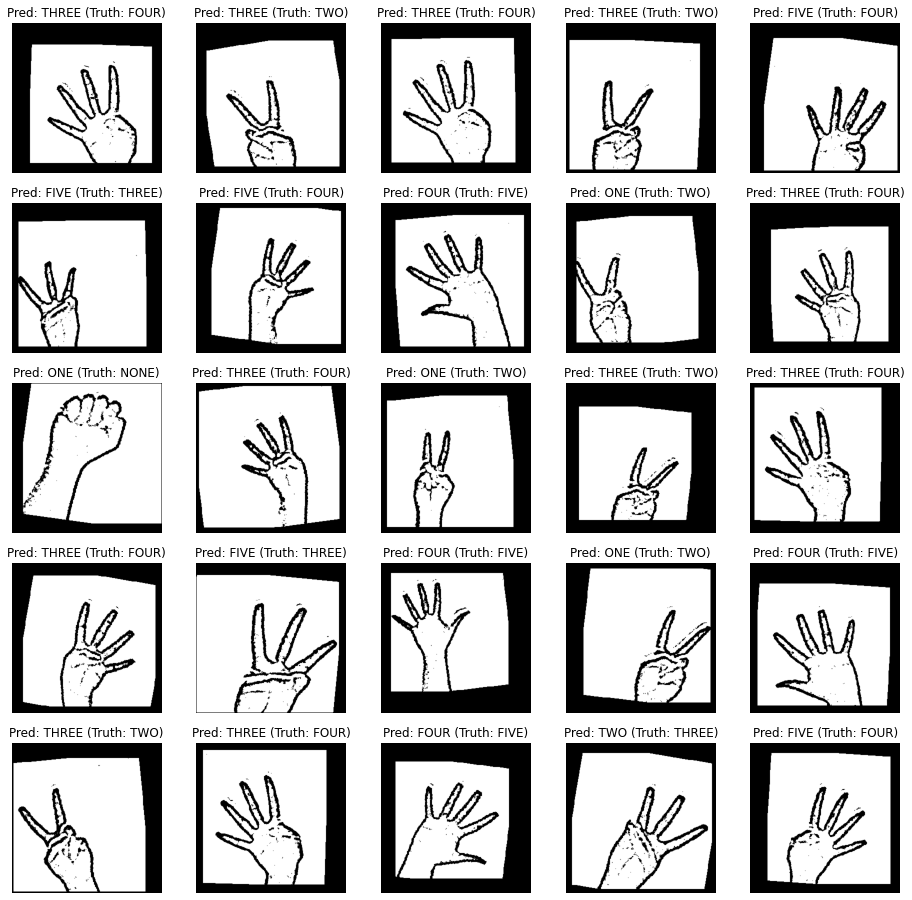

In [7]:
# display bad predictions
plt.figure(figsize=(16, 16))
for idx in range(min(25,len(incorrect_examples))):
    plt.subplot(5,5,idx+1)
    img = incorrect_examples[idx]
    plt.axis('off')
    plt.title("Pred: {} (Truth: {})".format(class_names[incorrect_preds[idx]], class_names[incorrect_target[idx]]))
    plt.imshow(img, cmap='gray')

In [8]:
# compare both elements
print(all_test_targets[:25])
print(all_test_preds[:25])
# print(len(all_test_preds.argmax(dim=1))

[0, 0, 4, 1, 4, 2, 1, 5, 4, 2, 2, 5, 3, 1, 1, 5, 0, 0, 4, 3, 0, 1, 1, 5, 5]
[0, 0, 4, 1, 4, 2, 1, 5, 4, 2, 2, 5, 3, 1, 1, 5, 0, 0, 4, 3, 0, 1, 1, 5, 5]


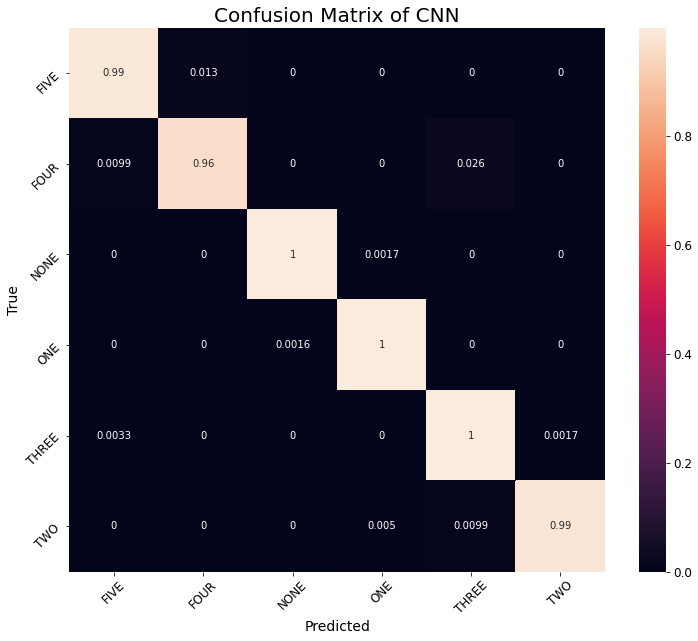

In [9]:
from sklearn.metrics import confusion_matrix 
import seaborn as sn
plt.figure(figsize=(12,10))
cm = confusion_matrix(all_test_targets, all_test_preds)
cm = cm / cm.sum(axis=1) # normalize
ax = sn.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion Matrix of CNN', fontsize = 20)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

A confusion matrix counts the number of predicted values against the true values (targets). It tells us where the predicted values fall relative to the true values. It helps summarize the cases that are misclassified as shown above. 

The network performs generally well but has the most trouble predicting four fingers, usually confusing it for three fingers. This issue seems most prevelant when the four fingers are rotated to the side. Since the convolutional network has a never changing rotation, this problem might be improved with more data or by making adjustments to the model. For the scope of this project this issue is deemed acceptable but could be improved in the future. It also appears that the networks usually under-counts the number of fingers and this is likely in part due to applying augmentations, as previosly observed. 